In [248]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', 'analysis'))

In [249]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import h5py
import json
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy import signal
from functools import reduce
from imports import *
from analysis.loading import load_session_data
from session.sessions import selected_009266, selected_008229, selected_009265

import matplotlib.pyplot as plt

In [250]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [251]:
#selected_009266
#selected_008229
#selected_009265

selected = [
'009265_hippoSIT_2023-03-01_10-46-12',
'009265_hippoSIT_2023-03-02_09-32-54',
'009265_hippoSIT_2023-03-02_16-27-42',
'009265_hippoSIT_2023-03-02_20-11-35',
'009265_hippoSIT_2023-03-03_09-37-07',
'009265_hippoSIT_2023-03-03_16-00-47',
'009265_hippoSIT_2023-03-04_11-12-04',
'009265_hippoSIT_2023-03-05_11-52-17',
'009265_hippoSIT_2023-03-05_18-31-32',
'009265_hippoSIT_2023-03-08_18-10-07',
'009265_hippoSIT_2023-03-09_20-03-08',
'009265_hippoSIT_2023-03-10_09-57-34',
'009265_hippoSIT_2023-04-13_09-54-39',
'009265_hippoSIT_2023-04-20_11-39-02',
]

## Read MoSeq source file

In [252]:
source

'/home/sobolev/nevermind/Andrey/data'

In [266]:
#source = '/home/sobolev/nevermind/Miguel/MoSeq/TrainedModels/MoSeqProject_ALLhippoSIT/2023_01_22-16_22_54'
#source = '/home/sobolev/nevermind/Andrey/analysis/DLC/MoSeq/10fps'
source = '/home/sobolev/nevermind/Andrey/analysis/MoSeq/results'
#source = '/mnt/nevermind.data-share/ag-grothe/Andrey/analysis/MoSeq/results'
session = selected[13]

filt = [s for s in os.listdir(source) if s.startswith(session)]
if len(filt) > 0:
    moseq_file = os.path.join(source, filt[0])
    print("Found MoSeq file")
else:
    print("No MoSeq file for that session")

Found MoSeq file


In [254]:
ds = pd.read_csv(moseq_file)
ds.head()

,syllables reindexed,syllables non-reindexed,centroid x,centroid y,heading,estimated left_eye x,estimated left_eye y,estimated right_eye x,estimated right_eye y,estimated left_ear x,...,estimated right_hip y,latent_state 0,latent_state 1,latent_state 2,latent_state 3,latent_state 4,latent_state 5,latent_state 6,latent_state 7,latent_state 8
0,18,31,820.2806,418.1493,-0.4341,840.9380,408.5147,841.4222,413.7998,837.4897,...,455.4309,4.3794,-3.4450,-2.8555,6.6947,3.9485,-4.4517,2.9135,4.2440,-4.3708
1,18,31,822.2307,414.8923,-0.3182,841.6561,406.8895,833.2612,423.4839,838.8333,...,433.0694,-0.5961,-0.2045,-5.1898,-1.5694,0.6426,2.1901,-1.0122,2.1074,-0.3630
2,18,31,824.5801,413.0953,0.1703,839.9732,405.2259,837.9043,422.6200,825.7775,...,424.1787,-2.1762,0.7893,1.4437,-0.7228,-2.7279,0.0825,-2.3293,-0.5377,-0.4230
3,18,31,823.9743,414.9227,-0.0913,836.7239,405.6447,837.0373,422.2148,824.6690,...,427.6213,-2.2321,1.1391,0.1548,-0.9450,-2.1446,1.5696,-2.0151,0.4035,-0.2447
4,18,31,823.7985,415.7910,-0.1222,836.2926,405.6178,836.7954,423.3077,823.9783,...,429.2674,-2.2510,1.2411,-0.0395,-0.7373,-2.6170,1.4257,-2.6642,0.2269,-0.3372


## Create moseq processed file in the session

In [255]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source = '/mnt/nevermind.data-share/ag-grothe/Andrey/data'

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5_file     = os.path.join(sessionpath, session + '.h5')
moseq_file  = os.path.join(sessionpath, 'moseq.h5')

In [256]:
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])
    cfg = json.loads(f['processed'].attrs['parameters'])

In [257]:
# compare lengths of timeline (~100Hz) and MoSeq detected coords / syllables
ds1 = ds.copy()
tl.shape, ds1.shape

((119997, 7), (35918, 40))

In [258]:
# select only required columns
#columns_to_drop = ['Unnamed: 0', 'session_name', 'uuid', 'onset']
#ds1 = ds1.drop(columns=columns_to_drop)

In [259]:
def px_to_meters(cfg, x, y):  # convert pixels to meters
    cfg_pos = cfg['position']
    pixel_size = cfg_pos['floor_r_in_meters'] / float(cfg_pos['floor_radius'])
    x_m = float(cfg_pos['arena_x'] - x) * pixel_size * (-1 if cfg_pos['flip_x'] else 1)
    y_m = float(cfg_pos['arena_y'] - y) * pixel_size * (-1 if cfg_pos['flip_y'] else 1)
    return x_m, y_m

In [260]:
# convert pixels to meters in all variables
variables = [x[:-2] for x in ds1.columns if x.find(' x') > 0]
for variable in variables:
    var_x, var_y = variable + ' x', variable + ' y'
    converted = np.array([px_to_meters(cfg, x, y) for x, y in zip(ds[var_x], ds[var_y])])
    ds1[var_x] = converted[:, 0]
    ds1[var_y] = converted[:, 1]
    
print("Converted %d variables" % len(variables))

Converted 14 variables


In [261]:
# interpolate syllables assuming frames are evenly distributed
t_start, t_end = tl[0][0], tl[-1][0]

x_moseq = np.linspace(t_start, t_end, len(ds1))  # moseq timeline in seconds
moseq_matrix = np.zeros((len(tl), len(ds1.columns)))  # collect moseq data into numpy array

curr_idx = 0
for i, t in enumerate(tl[:, 0]):
    if curr_idx < len(x_moseq) - 1 and \
        np.abs(t - x_moseq[curr_idx]) > np.abs(t - x_moseq[curr_idx + 1]):
        curr_idx += 1
        
    moseq_matrix[i] = np.array(ds1.iloc[curr_idx])

In [262]:
# create a DataFrame from it
moseq_df = pd.DataFrame(moseq_matrix, columns=ds1.columns)

Text(0, 0.5, 'X Position')

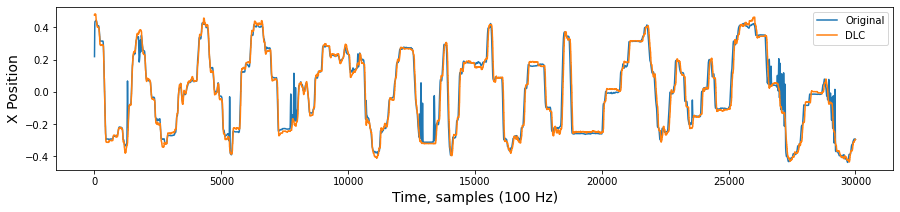

In [263]:
# test centroid position
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(tl[:, 1][:30000], label='Original')
ax.plot(moseq_matrix[:, 2][:30000], label='DLC')
ax.legend(loc='upper right')
ax.set_xlabel('Time, samples (100 Hz)', fontsize=14)
ax.set_ylabel('X Position', fontsize=14)

In [264]:
# save moseq data to the session folder
with h5py.File(moseq_file, 'w') as f:
    ds_h5 = f.create_dataset('moseq', data=moseq_matrix)
    ds_h5.attrs['headers'] = ', '.join(list(ds1.columns))